In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))

from sklearn.model_selection import StratifiedKFold, train_test_split

from sklearn.preprocessing import MinMaxScaler
import numpy as np
from utils.metrics import get_classification_metrics, get_probability_measures, get_lift_demotion_scores

In [2]:
import random 
from types import SimpleNamespace

import torch

from torch.utils.data import DataLoader

from models.autoencoder import VariationalAutoEncoder, AutoEncoder
from models.mlp import MLP
from utils.data_utils import TorchDataset

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
def merge_strings_and_integers(val):
    try:
        return int(val)
    except:
        return 'other'

In [5]:
df = pd.read_csv("final_autof.csv")
df.drop([
    'MODE(consumptions.MS_METER_NBR)',
    'MODE(representations.SUPPLIER)',
    'MODE(representations.SUPPLIER_TO)',
], axis=1, inplace=True)
df.dropna(subset=['number_of_zeros'], inplace=True)


df['MODE(consumptions.BS_RATE)'] = df['MODE(consumptions.BS_RATE)'].apply(merge_strings_and_integers)
df = df.drop(['rec_id'], axis=1)
df = df.drop_duplicates()
df['MODE(requests.REQUEST_TYPE)'] = df['MODE(requests.REQUEST_TYPE)'].replace(0, 'unknown')
df = pd.get_dummies(df, columns=['MODE(requests.REQUEST_TYPE)'], prefix='MODE(requests.REQUEST_TYPE)')
df = pd.get_dummies(df, columns=['MODE(consumptions.BS_RATE)'], prefix='MODE(consumptions.BS_RATE)')
df = df.drop(['voltage'], axis=1)
df.fillna(0, inplace=True)
df.head()

/tmp/ipykernel_14145/2214542397.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("final_autof.csv")


,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,MODE(consumptions.BS_RATE)_40,MODE(consumptions.BS_RATE)_41,MODE(consumptions.BS_RATE)_42,MODE(consumptions.BS_RATE)_43,MODE(consumptions.BS_RATE)_44,MODE(consumptions.BS_RATE)_52,MODE(consumptions.BS_RATE)_53,MODE(consumptions.BS_RATE)_54,MODE(consumptions.BS_RATE)_55,MODE(consumptions.BS_RATE)_other
0,4.0,135.0,64.250000,12.0,1.0,1.0,0.758461,54.389797,257.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,10.0,127.0,51.900000,0.0,1.0,2.0,0.783315,43.072162,519.0,2.0,...,0,0,0,0,0,0,0,0,0,0
2,12.0,6068.0,3924.166667,2446.0,1.0,1.0,0.574519,1012.516472,47090.0,28.0,...,0,0,0,0,0,0,0,0,0,0
3,6.0,1061.0,479.333333,7.0,2.0,1.0,0.020392,409.340282,2876.0,4.0,...,0,0,0,0,0,0,0,0,0,0
4,24.0,1247.0,536.833333,0.0,2.0,1.0,0.537625,335.364392,12884.0,4.0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df = df.drop_duplicates()
print(len(df.loc[df.target == 1]))
df.head()

1552


,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,MODE(consumptions.BS_RATE)_40,MODE(consumptions.BS_RATE)_41,MODE(consumptions.BS_RATE)_42,MODE(consumptions.BS_RATE)_43,MODE(consumptions.BS_RATE)_44,MODE(consumptions.BS_RATE)_52,MODE(consumptions.BS_RATE)_53,MODE(consumptions.BS_RATE)_54,MODE(consumptions.BS_RATE)_55,MODE(consumptions.BS_RATE)_other
0,4.0,135.0,64.250000,12.0,1.0,1.0,0.758461,54.389797,257.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,10.0,127.0,51.900000,0.0,1.0,2.0,0.783315,43.072162,519.0,2.0,...,0,0,0,0,0,0,0,0,0,0
2,12.0,6068.0,3924.166667,2446.0,1.0,1.0,0.574519,1012.516472,47090.0,28.0,...,0,0,0,0,0,0,0,0,0,0
3,6.0,1061.0,479.333333,7.0,2.0,1.0,0.020392,409.340282,2876.0,4.0,...,0,0,0,0,0,0,0,0,0,0
4,24.0,1247.0,536.833333,0.0,2.0,1.0,0.537625,335.364392,12884.0,4.0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
print("Bincount of y:", df['target'].value_counts())

Bincount of y: 0.0    698967
1.0      1552
Name: target, dtype: int64


In [8]:
train, val = train_test_split(
    df, test_size=0.2, 
    random_state=42, shuffle=True, 
    stratify=df.target.values)

In [9]:
train.target.value_counts(), val.target.value_counts()

(0.0    559173
 1.0      1242
 Name: target, dtype: int64,
 0.0    139794
 1.0       310
 Name: target, dtype: int64)

In [10]:
X_train = train.drop('target', axis=1)
y_train = train['target']
X_val = val.drop('target', axis=1)
y_val = val['target']

In [11]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [12]:
train_dataset = TorchDataset(
    X=torch.tensor(X_train).float(),
    y=torch.tensor(y_train.to_numpy()).float()
)  # reconstruction
val_dataset = TorchDataset(
    X=torch.tensor(X_val).float(),
    y=torch.tensor(y_val.to_numpy()).float()
)

In [13]:
np.bincount(y_train), np.bincount(y_val)

(array([559173,   1242]), array([139794,    310]))

In [14]:
train_loader = DataLoader(
    train_dataset, batch_size=512, shuffle=False
)
val_loader = DataLoader(
    val_dataset, batch_size=512, shuffle=False
)

In [15]:
encoder = MLP(
    in_size=X_train.shape[1],
    layer_units=[64],
    out_size=32,
    vae=False) # do not use VAE
decoder = MLP(
    in_size=32, 
    layer_units=[64],
    out_size=X_train.shape[1]
)
model = AutoEncoder(encoder, decoder, classifier=True) # make it an AutoEncoder-based classifier.
model

AutoEncoder(
  (encoder): MLP(
    (MLP): Sequential(
      (0): Linear(in_features=88, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (decoder): MLP(
    (MLP): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=88, bias=True)
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=88, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), 
                                 lr=1e-3)
criterion = torch.nn.BCEWithLogitsLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
    
args = dict(model=model, train_loader=train_loader, 
            test_loader=val_loader,
            epochs=50, optimizer=optimizer, 
            criterion=criterion,
            reconstruction=False, vae=False,
            device=device, verbose=True, return_best=True)

cuda


Epoch: 1/50
[Train]	Loss=0.02704699800772907, Accuracy: 0.9977837852305881, Precision: 0.0, Recall: 0.0, F1: 0.0
		Brier score loss: 0.002204150899874122, ROC-AUC: 0.8280412681733724, PR-AUC: 0.014543843647715157
		Lift: 0.07, Demotion: 1.0, Weighted Score: 0.349
[Test]	Loss=0.017812978476285934, Accuracy: 0.9977873579626563, Precision: 0.0, Recall: 0.0, F1: 0.0
		Brier score loss: 0.0022010887555520752, ROC-AUC: 0.8206960518403346, PR-AUC: 0.016139193544650335
		Lift: 0.03, Demotion: 1.0, Weighted Score: 0.321

Epoch: 2/50
[Train]	Loss=0.01392961393060486, Accuracy: 0.9977837852305881, Precision: 0.0, Recall: 0.0, F1: 0.0
		Brier score loss: 0.0021815312965364785, ROC-AUC: 0.8711428037908745, PR-AUC: 0.0467028367304029
		Lift: 0.31, Demotion: 1.0, Weighted Score: 0.517
[Test]	Loss=0.01706920750439167, Accuracy: 0.9977873579626563, Precision: 0.0, Recall: 0.0, F1: 0.0
		Brier score loss: 0.00217857396345204, ROC-AUC: 0.8710649702534652, PR-AUC: 0.03630811545522408
		Lift: 0.13, Demotio

[Test]	Loss=0.011440642178058624, Accuracy: 0.9977944955176155, Precision: 0.5454545454545454, Recall: 0.01935483870967742, F1: 0.037383177570093455
		Brier score loss: 0.002140500205649184, ROC-AUC: 0.8847381538826486, PR-AUC: 0.061283118501254966
		Lift: 0.19, Demotion: 1.0, Weighted Score: 0.43299999999999994

Epoch: 16/50
[Train]	Loss=0.011990783136703721, Accuracy: 0.9978658672590848, Precision: 0.8833333333333333, Recall: 0.0426731078904992, F1: 0.08141321044546851
		Brier score loss: 0.002047594808926773, ROC-AUC: 0.9099932367051845, PR-AUC: 0.1309468952501704
		Lift: 0.74, Demotion: 1.0, Weighted Score: 0.8180000000000001
[Test]	Loss=0.011583914048969746, Accuracy: 0.9978016330725746, Precision: 0.5833333333333334, Recall: 0.02258064516129032, F1: 0.043478260869565216
		Brier score loss: 0.002141042858596302, ROC-AUC: 0.8848987357895742, PR-AUC: 0.0634756517791105
		Lift: 0.19, Demotion: 1.0, Weighted Score: 0.43299999999999994

Epoch: 17/50
[Train]	Loss=0.011934954016873417, A

Epoch: 29/50
[Train]	Loss=0.011401884466224695, Accuracy: 0.9979033394894855, Precision: 0.7964601769911505, Recall: 0.07246376811594203, F1: 0.13284132841328414
		Brier score loss: 0.001991159448990457, ROC-AUC: 0.9193832107700872, PR-AUC: 0.16682013749101582
		Lift: 0.83, Demotion: 1.0, Weighted Score: 0.881
[Test]	Loss=0.012669900432229042, Accuracy: 0.9977302575229829, Precision: 0.3333333333333333, Recall: 0.025806451612903226, F1: 0.04790419161676647
		Brier score loss: 0.002182057058316798, ROC-AUC: 0.8843511674090032, PR-AUC: 0.06324066225012451
		Lift: 0.19, Demotion: 1.0, Weighted Score: 0.43299999999999994

Epoch: 30/50
[Train]	Loss=0.011348354427588329, Accuracy: 0.9979104770571808, Precision: 0.8380952380952381, Recall: 0.07085346215780998, F1: 0.13066072754268745
		Brier score loss: 0.0019894570598076194, ROC-AUC: 0.920665979166444, PR-AUC: 0.16919324478859427
		Lift: 0.84, Demotion: 1.0, Weighted Score: 0.8879999999999999
[Test]	Loss=0.013246108777821064, Accuracy: 0.997

[Test]	Loss=0.019295262172818184, Accuracy: 0.9977445326329013, Precision: 0.39285714285714285, Recall: 0.035483870967741936, F1: 0.0650887573964497
		Brier score loss: 0.00217593516751319, ROC-AUC: 0.869734579498774, PR-AUC: 0.0550543277789477
		Lift: 0.19, Demotion: 1.0, Weighted Score: 0.43299999999999994

Epoch: 43/50
[Train]	Loss=0.010934443601415616, Accuracy: 0.9979515180714292, Precision: 0.7554347826086957, Recall: 0.11191626409017713, F1: 0.19495091164095374
		Brier score loss: 0.001949023100460072, ROC-AUC: 0.9254941669911985, PR-AUC: 0.19350811144200744
		Lift: 0.88, Demotion: 1.0, Weighted Score: 0.9159999999999999
[Test]	Loss=0.015507273375988007, Accuracy: 0.9976660195283503, Precision: 0.2926829268292683, Recall: 0.03870967741935484, F1: 0.06837606837606838
		Brier score loss: 0.0022129518538348504, ROC-AUC: 0.8725692574373259, PR-AUC: 0.05314088599822579
		Lift: 0.18, Demotion: 1.0, Weighted Score: 0.426

Epoch: 44/50
[Train]	Loss=0.010867796811704699, Accuracy: 0.9979

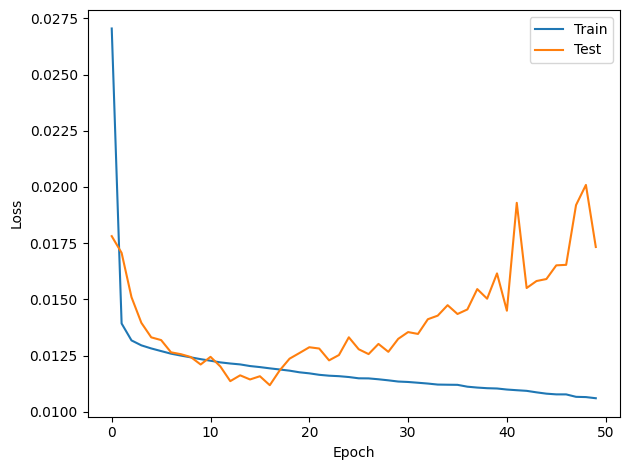

In [17]:
args = SimpleNamespace(**args)
model = model.fit(args)

In [49]:
df.head()

,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,MODE(consumptions.BS_RATE)_40,MODE(consumptions.BS_RATE)_41,MODE(consumptions.BS_RATE)_42,MODE(consumptions.BS_RATE)_43,MODE(consumptions.BS_RATE)_44,MODE(consumptions.BS_RATE)_52,MODE(consumptions.BS_RATE)_53,MODE(consumptions.BS_RATE)_54,MODE(consumptions.BS_RATE)_55,MODE(consumptions.BS_RATE)_other
0,4.0,135.0,64.250000,12.0,1.0,1.0,0.758461,54.389797,257.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,10.0,127.0,51.900000,0.0,1.0,2.0,0.783315,43.072162,519.0,2.0,...,0,0,0,0,0,0,0,0,0,0
2,12.0,6068.0,3924.166667,2446.0,1.0,1.0,0.574519,1012.516472,47090.0,28.0,...,0,0,0,0,0,0,0,0,0,0
3,6.0,1061.0,479.333333,7.0,2.0,1.0,0.020392,409.340282,2876.0,4.0,...,0,0,0,0,0,0,0,0,0,0
4,24.0,1247.0,536.833333,0.0,2.0,1.0,0.537625,335.364392,12884.0,4.0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
tmp_df = df.copy()

In [64]:
def get_loss_and_hidden(row, model):
    model.eval()
    model.to('cpu') # move model to cpu
    tmp_X = row.drop('target') # get the features
    target = row.target # get the target
    input_tensor = torch.tensor(tmp_X.values, dtype=torch.float32) # transform to torch tensor
    target = torch.tensor(target, dtype=torch.float32)
    
    encoded = model.encode(input_tensor) # get the latent
    decoded = model(input_tensor) # get the prediction
    loss = torch.nn.functional.binary_cross_entropy_with_logits(decoded[0], target) # calculate the loss
    
    return loss.item(), encoded.detach().numpy().tolist()

In [65]:
tmp_tmp = tmp_df.copy()
tmp_tmp = tmp_tmp.iloc[:20]

In [66]:
tmp_tmp.drop(['target'], axis=1, inplace=True)

In [67]:
X = df.drop(['target'], axis=1)
X = scaler.transform(X)
y = df['target'].values
cols = list(df.columns)
cols.remove("target")
tmp = pd.DataFrame(X, columns=cols)
tmp['target'] = y

In [68]:
tmp[['loss', 'hidden']] = tmp.apply(lambda row: pd.Series(get_loss_and_hidden(row, model)), axis=1)

In [69]:
tmp.head()

,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,MODE(consumptions.BS_RATE)_43,MODE(consumptions.BS_RATE)_44,MODE(consumptions.BS_RATE)_52,MODE(consumptions.BS_RATE)_53,MODE(consumptions.BS_RATE)_54,MODE(consumptions.BS_RATE)_55,MODE(consumptions.BS_RATE)_other,target,loss,hidden
0,0.025862,0.000036,0.000064,0.000012,0.00,0.0,0.382790,0.000083,0.000043,0.033333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002384,"[-0.255097359418869, 0.11956769227981567, 0.09..."
1,0.077586,0.000034,0.000052,0.000000,0.00,0.2,0.384822,0.000066,0.000087,0.033333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000312,"[0.900549590587616, 1.1085796356201172, -0.345..."
2,0.094828,0.001637,0.003924,0.002446,0.00,0.0,0.367747,0.001549,0.007935,0.900000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000173,"[0.45306217670440674, 0.7686377763748169, -0.0..."
3,0.043103,0.000286,0.000479,0.000007,0.25,0.0,0.322431,0.000626,0.000485,0.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003322,"[-0.8019350171089172, -0.3765203356742859, 0.7..."
4,0.198276,0.000336,0.000537,0.000000,0.25,0.0,0.364730,0.000513,0.002171,0.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004067,"[-0.7476450800895691, 0.09783019125461578, 0.3..."


In [70]:
len(tmp)

700519

In [72]:
tmp.head()

,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,MODE(consumptions.BS_RATE)_43,MODE(consumptions.BS_RATE)_44,MODE(consumptions.BS_RATE)_52,MODE(consumptions.BS_RATE)_53,MODE(consumptions.BS_RATE)_54,MODE(consumptions.BS_RATE)_55,MODE(consumptions.BS_RATE)_other,target,loss,hidden
0,0.025862,0.000036,0.000064,0.000012,0.00,0.0,0.382790,0.000083,0.000043,0.033333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002384,"[-0.255097359418869, 0.11956769227981567, 0.09..."
1,0.077586,0.000034,0.000052,0.000000,0.00,0.2,0.384822,0.000066,0.000087,0.033333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000312,"[0.900549590587616, 1.1085796356201172, -0.345..."
2,0.094828,0.001637,0.003924,0.002446,0.00,0.0,0.367747,0.001549,0.007935,0.900000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000173,"[0.45306217670440674, 0.7686377763748169, -0.0..."
3,0.043103,0.000286,0.000479,0.000007,0.25,0.0,0.322431,0.000626,0.000485,0.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003322,"[-0.8019350171089172, -0.3765203356742859, 0.7..."
4,0.198276,0.000336,0.000537,0.000000,0.25,0.0,0.364730,0.000513,0.002171,0.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004067,"[-0.7476450800895691, 0.09783019125461578, 0.3..."


In [73]:
tmp2 = pd.DataFrame(tmp['hidden'].apply(pd.Series).values, columns=[f't_hidden_{i}' for i in range(1, 33)])

In [74]:
tmp3 = pd.concat([tmp, tmp2], axis=1)

In [75]:
tmp3.head()

,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,t_hidden_23,t_hidden_24,t_hidden_25,t_hidden_26,t_hidden_27,t_hidden_28,t_hidden_29,t_hidden_30,t_hidden_31,t_hidden_32
0,0.025862,0.000036,0.000064,0.000012,0.00,0.0,0.382790,0.000083,0.000043,0.033333,...,-0.200738,1.677683,1.607058,-0.097354,-0.945015,0.023192,-0.231664,-0.234937,-0.792697,-1.055135
1,0.077586,0.000034,0.000052,0.000000,0.00,0.2,0.384822,0.000066,0.000087,0.033333,...,0.234075,1.257790,1.099965,0.268211,-0.205435,-0.297397,-0.193492,-0.355553,-0.878955,-0.729695
2,0.094828,0.001637,0.003924,0.002446,0.00,0.0,0.367747,0.001549,0.007935,0.900000,...,-0.062386,1.726098,1.359127,-0.246991,-0.710691,0.044353,-1.086494,-0.080327,0.226533,-0.637788
3,0.043103,0.000286,0.000479,0.000007,0.25,0.0,0.322431,0.000626,0.000485,0.100000,...,-0.077913,0.708339,1.308034,-0.366745,-0.736609,-0.246300,0.084537,-1.052447,-0.190187,-0.436573
4,0.198276,0.000336,0.000537,0.000000,0.25,0.0,0.364730,0.000513,0.002171,0.100000,...,-0.365520,0.304948,1.052117,0.060189,-0.703044,0.253437,-0.312321,-0.626512,-0.150037,-0.063584


In [76]:
tmp3.drop(['hidden'], axis=1, inplace=True)

In [77]:
tmp3.head()

,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,t_hidden_23,t_hidden_24,t_hidden_25,t_hidden_26,t_hidden_27,t_hidden_28,t_hidden_29,t_hidden_30,t_hidden_31,t_hidden_32
0,0.025862,0.000036,0.000064,0.000012,0.00,0.0,0.382790,0.000083,0.000043,0.033333,...,-0.200738,1.677683,1.607058,-0.097354,-0.945015,0.023192,-0.231664,-0.234937,-0.792697,-1.055135
1,0.077586,0.000034,0.000052,0.000000,0.00,0.2,0.384822,0.000066,0.000087,0.033333,...,0.234075,1.257790,1.099965,0.268211,-0.205435,-0.297397,-0.193492,-0.355553,-0.878955,-0.729695
2,0.094828,0.001637,0.003924,0.002446,0.00,0.0,0.367747,0.001549,0.007935,0.900000,...,-0.062386,1.726098,1.359127,-0.246991,-0.710691,0.044353,-1.086494,-0.080327,0.226533,-0.637788
3,0.043103,0.000286,0.000479,0.000007,0.25,0.0,0.322431,0.000626,0.000485,0.100000,...,-0.077913,0.708339,1.308034,-0.366745,-0.736609,-0.246300,0.084537,-1.052447,-0.190187,-0.436573
4,0.198276,0.000336,0.000537,0.000000,0.25,0.0,0.364730,0.000513,0.002171,0.100000,...,-0.365520,0.304948,1.052117,0.060189,-0.703044,0.253437,-0.312321,-0.626512,-0.150037,-0.063584


In [78]:
tmp3.rename({'loss': 'auto_loss'}, axis=1, inplace=True)

In [79]:
tmp3.head()

,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,t_hidden_23,t_hidden_24,t_hidden_25,t_hidden_26,t_hidden_27,t_hidden_28,t_hidden_29,t_hidden_30,t_hidden_31,t_hidden_32
0,0.025862,0.000036,0.000064,0.000012,0.00,0.0,0.382790,0.000083,0.000043,0.033333,...,-0.200738,1.677683,1.607058,-0.097354,-0.945015,0.023192,-0.231664,-0.234937,-0.792697,-1.055135
1,0.077586,0.000034,0.000052,0.000000,0.00,0.2,0.384822,0.000066,0.000087,0.033333,...,0.234075,1.257790,1.099965,0.268211,-0.205435,-0.297397,-0.193492,-0.355553,-0.878955,-0.729695
2,0.094828,0.001637,0.003924,0.002446,0.00,0.0,0.367747,0.001549,0.007935,0.900000,...,-0.062386,1.726098,1.359127,-0.246991,-0.710691,0.044353,-1.086494,-0.080327,0.226533,-0.637788
3,0.043103,0.000286,0.000479,0.000007,0.25,0.0,0.322431,0.000626,0.000485,0.100000,...,-0.077913,0.708339,1.308034,-0.366745,-0.736609,-0.246300,0.084537,-1.052447,-0.190187,-0.436573
4,0.198276,0.000336,0.000537,0.000000,0.25,0.0,0.364730,0.000513,0.002171,0.100000,...,-0.365520,0.304948,1.052117,0.060189,-0.703044,0.253437,-0.312321,-0.626512,-0.150037,-0.063584


In [81]:
tt = tmp3[['auto_loss', 't_hidden_1', 't_hidden_2', 't_hidden_3', 't_hidden_4',
          't_hidden_5', 't_hidden_6', 't_hidden_7', 't_hidden_8',
          't_hidden_9', 't_hidden_10', 't_hidden_11', 't_hidden_12',
          't_hidden_13', 't_hidden_14', 't_hidden_15', 't_hidden_16',
          't_hidden_17', 't_hidden_18', 't_hidden_19', 't_hidden_20',
          't_hidden_21', 't_hidden_22', 't_hidden_23', 't_hidden_24',
          't_hidden_25', 't_hidden_26', 't_hidden_27', 't_hidden_28',
          't_hidden_29', 't_hidden_30', 't_hidden_31', 't_hidden_32']]

In [82]:
len(df), len(tt)

(700519, 700519)

In [83]:
tt.to_csv("000.autoencoder_classifier_encoded.csv", index=False)